# Semana 6: Reresión polinomial, _over/underfitting_, _test/train split_, regularización

# Recapitulando la regresión lineal

De manera general, podemos escribir los modelos lineales como (ya veremos ejemplos....):

$$\vec y = X \cdot \vec \omega$$
donde $$X = \begin{pmatrix}
1&\; x_1^{(1)}&\; \dots&\;x_M^{(1)} \\
1&\; x_1^{(2)}&\; \dots&\;x_M^{(2)} \\
\vdots&\;\vdots&\;\ddots&\;\vdots \\
1&\; x_1^{(N)}&\; \dots&\;x_M^{(N)}
\end{pmatrix}$$ es la _matriz de diseño_, o, simplemente, el conjunto de datos con el que estamos entrenando. Cada fila representa una muestra, y cada columna una característica.

La principal característica de los modelos lineales es la relación lineal entre la salida $\vec y$ y los _parámetros del modelo_ $\vec \omega$, mientras que la dependencia de las variables predictoras puede ser arbitraria. De hecho, realizando ingeniería de _features_ podemos transformar nuestras variables iniciales en otras nuevas, que pueden representarse como un mapeo: $$ X \rightarrow X' = f(X).$$

La función $f(\vec x) = \vec x'$ se aplica fila por fila a $X$, y define una _base_ para la regresión lineal. Una forma sencilla de generalizar nuestros modelos lineales a curvas suaves es utilizar una **_Base Polinómica_** para la regresión. Esto puede ser pensado como una transformación de nuestras características $$ x \rightarrow f(x) = (x^0, x^1, x^2, \dots, x^M) $$ para un problema univariado. La correspondiente _matriz de diseño_ tiene la misma forma que antes, con el mapeo $x_i^{(j)} = (x^{(j)})^i $, que es la potencia $i$-ésima de la muestra $j$-ésima.

En este notebook, experimentaremos con este modelo y trataremos de encontrar una manera de aprender de los datos el mejor valor del _hiperparámetro_ $M$.

## Generación de los datos

Para fines didácticos, vamos a generar datos sintéticos que querremos ajustar. Los generaremos como una función analítica a la que añadiremos un poco de ruido gaussiano aleatorio.

### Armemos un conjunto de datos fictício *linear en la variable x*

In [64]:
import numpy as np
import matplotlib.pyplot as plt

N_SAMPLES = 20 # cuantos datos vamos a generar (cuantos pares {t,x}, líneas de una base de datos, etc.)
x = np.linspace(0,1,num=N_SAMPLES).reshape(-1,1)

# Fijamos la semilla aleatoria, por si queremos reproducir exactamente los mismos resultados en otro momento
np.random.seed(42)

# esta es la función linear verdadera que queremos modelizar. Generamos puntos a partir de ella
def mi_recta(x):
    return 4 * x + 9

# Agregamos ruido a los datos
t = mi_recta(x) + 0.5*np.random.randn(N_SAMPLES,1)


Veamos como quedaron esos puntos

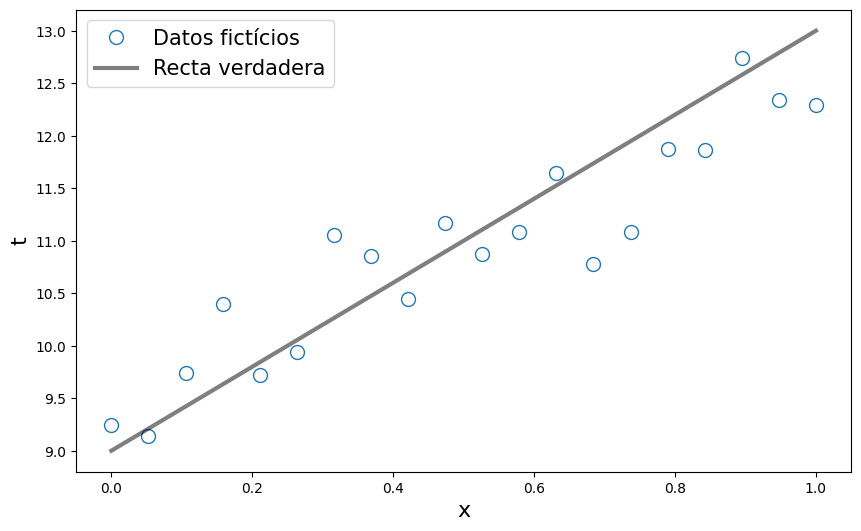

In [116]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

x_ = np.linspace(0,1, 100).reshape(-1,1)
ax.plot(x, t, 'o', ms=10, mfc='None', label='Datos fictícios')
# ax.plot(x_, models[i].predict(x_), 'r-', lw=3, alpha=0.8, label='Predicted curve')
ax.plot(x_, mi_recta(x_), 'k-', lw=3, alpha=0.5, label='Recta verdadera')
ax.legend(loc=2, fontsize=15)
    
plt.xlabel('x', fontsize=16)
plt.ylabel('t', fontsize=16)
plt.show()

¡Podemos generar tantos datos cuanto querramos!
Conocemos la "función verdadera" que queremos modelar, podemos elegir el scatter, etc. etc.


---



Bien, ahora vamos a ajustar los puntos, por una recta a ver que tan bien nos sale 

Como en la clase anterior, para modelar los datos de arriba, podemos elegir una familia de modelos. Acá vmaos a elegir a los modelos lineales (y por ahora simples; es decir con una única variable predictora).

El modelo de regresión lineal más sencillo relaciona una variable *target* con la covariable, *x_1*, utilizando esta fórmula:

$$
t = \omega_0 + \omega_1 \cdot x\;\;,
$$

donde $\boldsymbol{\omega} = (\omega_0, \omega_1)$ es el **vector de parámetros del modelo**. 

Esta fórmula define una **familia de modelos**. Todos los modelos de esta familia se ven como rectas en el gráfico de arriba, pero dependiendo del valor del vector de parámetros, pueden verse muy diferentes.

Para obtener $\omega_0$ y $\omega_1$, haremos como en la clase anterior

Instanciemos el regresor lineal y ajustemos los datos.

In [85]:
from sklearn.linear_model import LinearRegression

# Instanciemos el modelo (le damos fit_intercept=True, para que ajuste también omega0)
lr = LinearRegression(fit_intercept=True)

# Ajustamos (como siempre, con el método fit)
lr.fit(x, t)

LinearRegression()

Podemos ver el valor de los parámetros encontrados. El parámetro que no acompaña a ninguna variable ($\omega_0$) está en el atributo `intercept_`. El resto (en este caso solo $\omega_1$) están en el atributo `coef_`.

In [86]:
omega_1 = lr.coef_[0]
omega_0 = lr.intercept_
print('omega_1 =', lr.coef_[0],'; omega_0 =', lr.intercept_)

omega_1 = [3.0541348] ; omega_0 = [9.38728332]


Veamos como queda en la figura

<ipython-input-117-93ec3103bff0>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x_, omega_1[0]*x_+omega_0[0], 'k-', lw=3, color='red', alpha=0.5, label='Modelo (recta)')


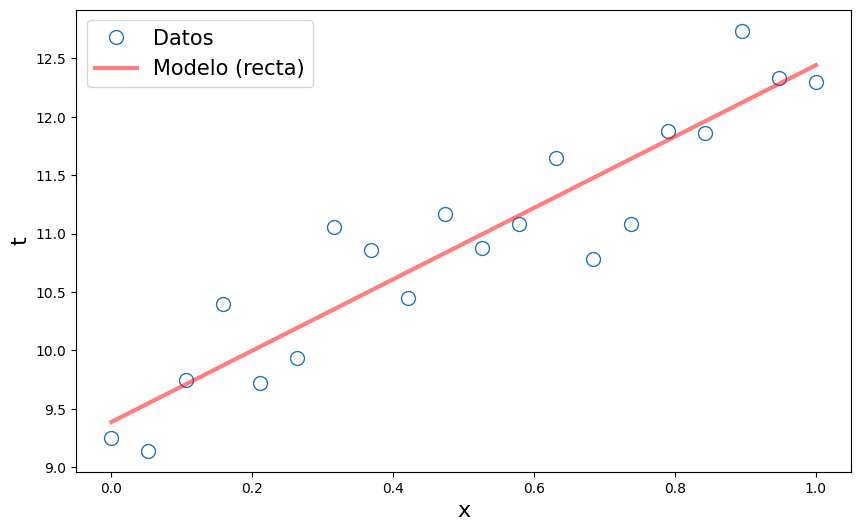

In [117]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

x_ = np.linspace(0,1, 100).reshape(-1,1)
ax.plot(x, t, 'o', ms=10, mfc='None', label='Datos')
ax.plot(x_, omega_1[0]*x_+omega_0[0], 'k-', lw=3, color='red', alpha=0.5, label='Modelo (recta)')
ax.legend(loc=2, fontsize=15)
    
plt.xlabel('x', fontsize=16)
plt.ylabel('t', fontsize=16)
plt.show()

Acuérdense que sabemos la "recta verdadera", así que podemos comparar los resultados

<ipython-input-118-34c0ce64d344>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x_, omega_1[0]*x_+omega_0[0], 'k-', lw=3, color='red', alpha=0.5, label='Modelo (recta)')


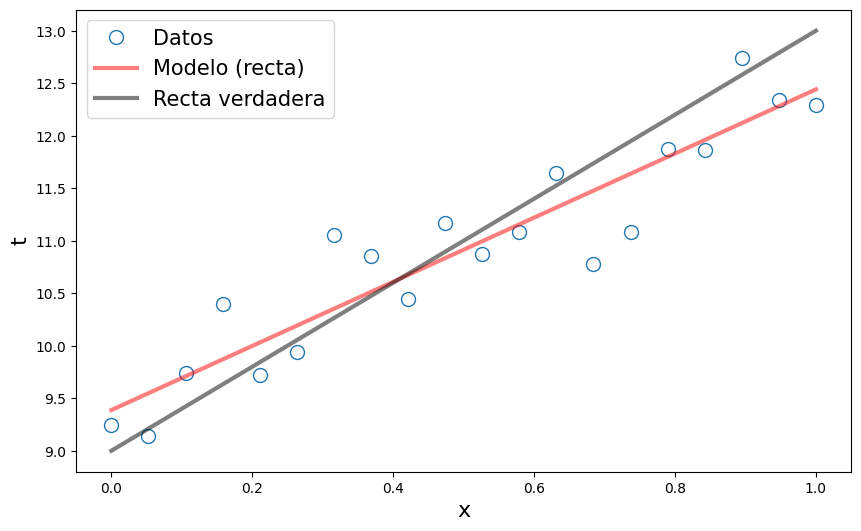

In [118]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

x_ = np.linspace(0,1, 100).reshape(-1,1)
ax.plot(x, t, 'o', ms=10, mfc='None', label='Datos')
ax.plot(x_, omega_1[0]*x_+omega_0[0], 'k-', lw=3, color='red', alpha=0.5, label='Modelo (recta)')
ax.plot(x_, mi_recta(x_), 'k-', lw=3, alpha=0.5, label='Recta verdadera')

ax.legend(loc=2, fontsize=15)
    
plt.xlabel('x', fontsize=16)
plt.ylabel('t', fontsize=16)
plt.show()

¿Que tanto cambian los resultados cuando agregamos más ruído o tenemos menos puntos?

¿Como cuantificamos todo eso? ¡Con el MAE o el MSE!
Resíduos, etc...

Como vimos en la clase anterior, la diferencia entre la predicción del modelo y los valores reales son los resíduos. Definimos las siguintes métricas para ver si el modelo representa bien o no a los datos:

**Error absoluto promedio (o medio)**, MAE, por sus siglas en inglés, que matemáticamente se escribe:

$$
\text{MAE} = \frac{1}{N} \left(|r_1| + |r_2| + \cdots + |r_N|\right) = \frac{1}{N} \sum_{i=1}^N \left| r_i \right |\;\;.
$$

**Rrror cuadrático promedio**, MSE:

$$
\text{MSE} = \frac{1}{N} \left(r_1^2 + r_2^2 + \cdots + r_N^2\right) = \frac{1}{N} \sum_{i=1}^N \left( r_i \right )^2\;\;.
$$

Ambas están implementadas en `sklearn`, en el paquete `metrics`, y se usan de manera idéntica: se les pase el valor de la variable target y lo que el modelo predice para esos datos.

Vamos a definir que es nuestra previsión basada en el modelo

In [131]:
pred = omega_1[0]*x+omega_0[0]

In [134]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('MAE [K$] = {:.6f}'.format(mean_absolute_error(t, pred)))
print('MSE [$^2]= {:.6f}'.format(mean_squared_error(t, pred)))

MAE [K$] = 0.301799
MSE [$^2]= 0.136490


Muchas veces se reporta la raíz del error cuadrático medio, RMSE

In [144]:
print('RMSE [K$]= {:.6f}'.format(np.sqrt(mean_squared_error(t, pred))))

RMSE [K$]= 9.042224


Como las métricas son sumas, ¿cambia mucho si cambiamos el número de puntos?

# Regresión Polinomial

## Armemos un conjunto de datos fictício *no-linear en la variable x*

In [38]:
N_SAMPLES = 20 # cuantos datos vamos a generar (cuantos pares {t,x}, líneas de una base de datos, etc.)
x = np.linspace(0,1,num=N_SAMPLES).reshape(-1,1)

# Fijamos la semilla aleatoria, por si queremos reproducir exactamente los mismos resultados en otro momento
np.random.seed(42)

# ¡Ahora la función que reremos modelizar no es más linear en la variable! Generamos puntos a partir de ella
def ground_truth(x):
    return 4 * x + np.sin(x*6)

# Agregamos ruido a los datos
t = ground_truth(x) + 0.5*np.random.randn(N_SAMPLES,1)

Veamos como queda en la figura:


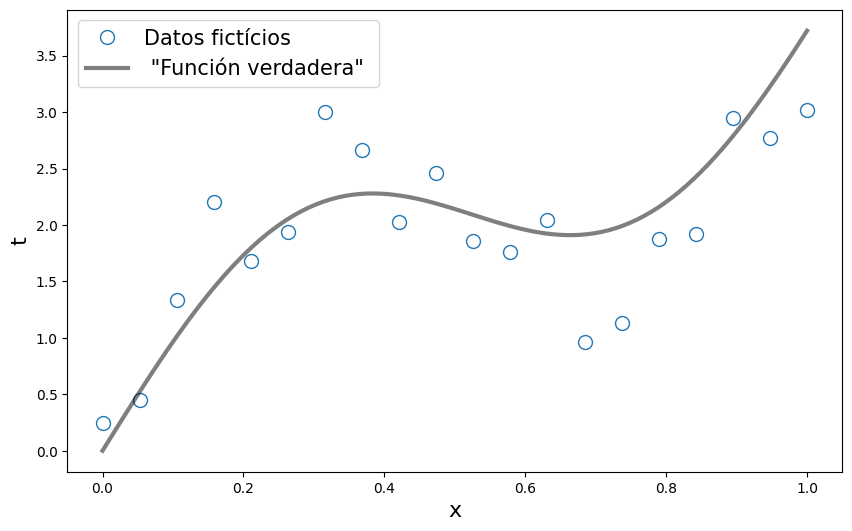

In [39]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

x_ = np.linspace(0,1, 100).reshape(-1,1)
ax.plot(x, t, 'o', ms=10, mfc='None', label='Datos fictícios')
# ax.plot(x_, models[i].predict(x_), 'r-', lw=3, alpha=0.8, label='Predicted curve')
ax.plot(x_, ground_truth(x_), 'k-', lw=3, alpha=0.5, label=' "Función verdadera" ')
ax.legend(loc=2, fontsize=15)
    
plt.xlabel('x', fontsize=16)
plt.ylabel('t', fontsize=16)
plt.show()

Ahora miremos solo a los puntos simulados (datos fictícios)

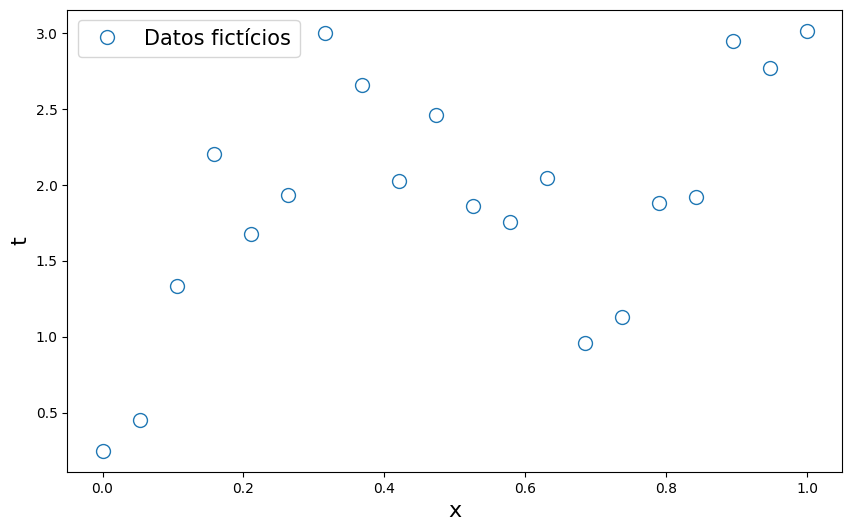

In [40]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

x_ = np.linspace(0,1, 100).reshape(-1,1)
ax.plot(x, t, 'o', ms=10, mfc='None', label='Datos fictícios')
# ax.plot(x_, models[i].predict(x_), 'r-', lw=3, alpha=0.8, label='Predicted curve')
#ax.plot(x_, ground_truth(x_), 'k-', lw=3, alpha=0.5, label=' "Función verdadera" ')
ax.legend(loc=2, fontsize=15)
    
plt.xlabel('x', fontsize=16)
plt.ylabel('t', fontsize=16)
plt.show()

Queremos aprender a predecir el valor te _t_ para un dado _x_. Para eso necesitamos un **modelo** ¿Si no sabemos la función real, que usaríamos para ajustar esos datos? ¿Una recta sería una buena elección?

### Ajuste por una recta

In [41]:
from sklearn.linear_model import LinearRegression

# Instanciemos el modelo (le damos fit_intercept=True, para que ajuste también omega0)
lr = LinearRegression(fit_intercept=True)

# Ajustamos (como siempre, con el método fit)
lr.fit(x, t)

omega_1 = lr.coef_[0]
omega_0 = lr.intercept_
print('omega_1 =', lr.coef_[0],'; omega_0 =', lr.intercept_)

omega_1 = [1.26470228] ; omega_0 = [1.28126807]


A ver como quedó

<ipython-input-6-7126253b808f>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x_, omega_1[0]*x_+omega_0[0], 'k-', lw=3, color='red', alpha=0.5, label='Modelo (recta)')


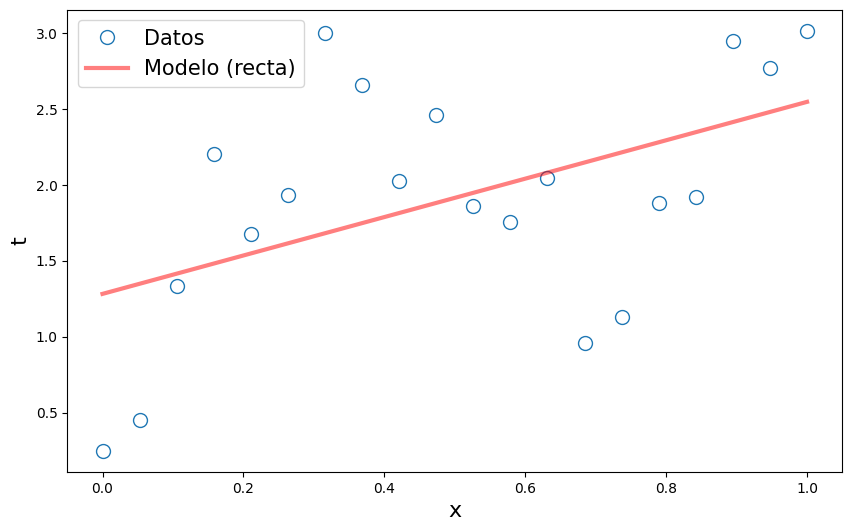

In [6]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

x_ = np.linspace(0,1, 100).reshape(-1,1)
ax.plot(x, t, 'o', ms=10, mfc='None', label='Datos')
ax.plot(x_, omega_1[0]*x_+omega_0[0], 'k-', lw=3, color='red', alpha=0.5, label='Modelo (recta)')

ax.legend(loc=2, fontsize=15)
    
plt.xlabel('x', fontsize=16)
plt.ylabel('t', fontsize=16)
plt.show()

Veamos las métricas de los resíduos

In [42]:
# previsióm del modelo de la recta
pred = omega_1[0]*x+omega_0[0]

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('MAE [K$] = {:.6f}'.format(mean_absolute_error(t, pred)))
print('MSE [$^2]= {:.6f}'.format(mean_squared_error(t, pred)))
print('RMSE [K$]= {:.6f}'.format(np.sqrt(mean_squared_error(t, pred))))

MAE [K$] = 0.549370
MSE [$^2]= 0.453727
RMSE [K$]= 0.673592


El modelo lineal no tiene suficiente flexibilidad. Para ajustarse mejor a los patrones presentes en nuestros datos, recurrimos a un modelo más flexible: el modelo de regresión polinomial. 

Se trata de un modelo lineal en el que nuestras características se amplían considerando también sus potencias hasta una determinada potencia $M$. Transformaremos la matriz $X$ mediante la clase `PolynomialFeatures` del módulo `preprocessing` de scikit-learn.

### Generando características (_features_) polinomiales: `PolynomialFeatures`

In [45]:
from sklearn.preprocessing import PolynomialFeatures

M = 2

poly = PolynomialFeatures(M)
x_poly = poly.fit_transform(x)

Así obtenemos la *matriz de diseño* $X$:

In [46]:
print(np.round(x_poly, 4))

[[1.     0.     0.    ]
 [1.     0.0526 0.0028]
 [1.     0.1053 0.0111]
 [1.     0.1579 0.0249]
 [1.     0.2105 0.0443]
 [1.     0.2632 0.0693]
 [1.     0.3158 0.0997]
 [1.     0.3684 0.1357]
 [1.     0.4211 0.1773]
 [1.     0.4737 0.2244]
 [1.     0.5263 0.277 ]
 [1.     0.5789 0.3352]
 [1.     0.6316 0.3989]
 [1.     0.6842 0.4681]
 [1.     0.7368 0.5429]
 [1.     0.7895 0.6233]
 [1.     0.8421 0.7091]
 [1.     0.8947 0.8006]
 [1.     0.9474 0.8975]
 [1.     1.     1.    ]]


**Pregunta:** ¿Qué dimensiones tienen esta matriz? ¿Qué pasa si cambiamos el valor de $M$? Prueben modificando la celda de arriba!

Ahora podemos ajustar nuestros datos utilizando estas características. Utilizamos exactamente la misma clase, `LinearRegression`. La única diferencia es que como tenemos una columna de 1's, tenemos que asegurarnos de que el algoritmo no intente ajustar también el sesgo (intercept).

In [48]:
lr = LinearRegression(fit_intercept=False)
lr.fit(x_poly, t)

LinearRegression(fit_intercept=False)

Veamos el valor de los coeficientes.

In [49]:
print(*lr.coef_)

[ 1.04365769  2.769568   -1.50486572]


Como antes, visualicemos las predicciones y calculemos el MSE

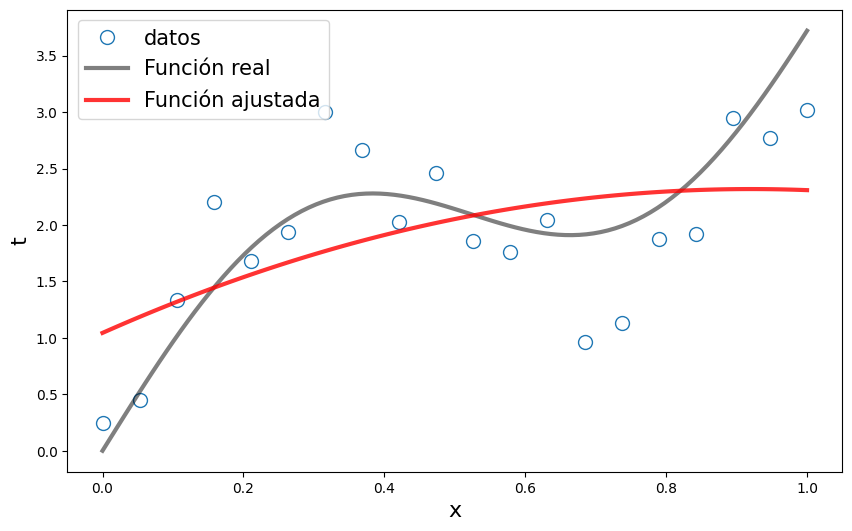

El MSE es: 0.44


In [50]:
from sklearn.metrics import mean_squared_error

predictions = lr.predict(poly.transform(x_))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

x_ = np.linspace(0,1, 100).reshape(-1,1)
ax.plot(x, t, 'o', ms=10, mfc='None', label='datos')
#ax.plot(x_train, t_train, 'o', ms=10, mfc='None', label='datos')
#ax.plot(x_test, t_test, 'or', ms=10, mfc='None', label='Test')
ax.plot(x_, ground_truth(x_), 'k-', lw=3, alpha=0.5, label='Función real')
ax.plot(x_, predictions, 'r-', lw=3, alpha=0.8, label='Función ajustada')
ax.legend(loc=2, fontsize=15)
    
plt.xlabel('x', fontsize=16)
plt.ylabel('t', fontsize=16)
plt.show()

error = mean_squared_error(t, lr.predict(x_poly))

print(f"""El MSE es: {round(error,2)}""")

### Hyper-parámetros y Pipelines

Ahora podemos ver que nuestro modelo tiene un **hiperparámetro**: el grado del polinomio $M$. Podemos variar este hiperparámetro, y por lo tanto variar nuestro modelo, para ver cómo se comporta.

Para ello, vamos a poner todo junto en un Pipeline. Un pipeline es una lista de tuplas `(nombre, modelo)`, en la que cada modelo tiene un método `fit` que se alimenta de la salida del modelo anterior. La entrada del primer modelo son las variables de entrada, y la salida de todos los modelos menos el último se obtiene a través del método `transform`. Esto nos permite armar una cadena de modelos que _transforman_ los datos de entrada, los cuales son alimentados en el último modelo que se llama _estimador_ y tiene un método `predict` que arroja la predicción de toda la tubería.

Veamos cómo se construye esto:

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def polynomial_regressor(M):
    pr = Pipeline([
        ('poly_features', PolynomialFeatures(M)),
        ('regressor', LinearRegression(fit_intercept=False) )])
    return pr

Ahora podemos hacer el ajuste cuadrático en un solo paso.

In [52]:
pr = polynomial_regressor(2)
pr.fit(x, t)

Pipeline(steps=[('poly_features', PolynomialFeatures()),
                ('regressor', LinearRegression(fit_intercept=False))])

Y poemos usar las funciones que definimos al principio para el cálculo del error.


In [55]:
error = mean_squared_error(t, pr.predict(x))

print(f"""El MSE es: {round(error,2)}""")

El MSE es: 0.44


Los nombres de cada tupla se utilizan como clave para acceder a cada uno de los _pasos_ del pipeline en el diccionario `named_steps`:

In [56]:
pr.named_steps

{'poly_features': PolynomialFeatures(),
 'regressor': LinearRegression(fit_intercept=False)}

Y esto puede usarse, por ejemplo, para obtener los valores de los parámetros ajustados.

In [57]:
pr.named_steps['regressor'].coef_

array([[ 1.04365769,  2.769568  , -1.50486572]])

## Aumentando el grado del polinomio.

Ahora, podemos iterar sobre ciertos grados del polinomio y ver cómo se comporta

In [62]:
# Crea una lista de grado
degrees = range(1, 10)

# Inicializa listas
errors = []
models = []

# Itera en todos los grados
for M in degrees:
    print(f"Grado del polinomio: {M}")
    
    # Create polynomial model
    pr = polynomial_regressor(M)
    
    # Fit 
    pr.fit(x, t)
    
    # Evaluate errors
    error_n = mean_squared_error(t, pr.predict(x))
    print(f"""El MSE es: {round(error_n,2)}""")    
    # guarda el resultado en listas
    errors.append(error_n)
    models.append(pr)

Grado del polinomio: 1
El MSE es: 0.45
Grado del polinomio: 2
El MSE es: 0.44
Grado del polinomio: 3
El MSE es: 0.14
Grado del polinomio: 4
El MSE es: 0.14
Grado del polinomio: 5
El MSE es: 0.11
Grado del polinomio: 6
El MSE es: 0.1
Grado del polinomio: 7
El MSE es: 0.1
Grado del polinomio: 8
El MSE es: 0.09
Grado del polinomio: 9
El MSE es: 0.09


¡Vemos que aumentar el grado del polinomio mejor el ajuste!
Veamos graficamente todos estos modelos.

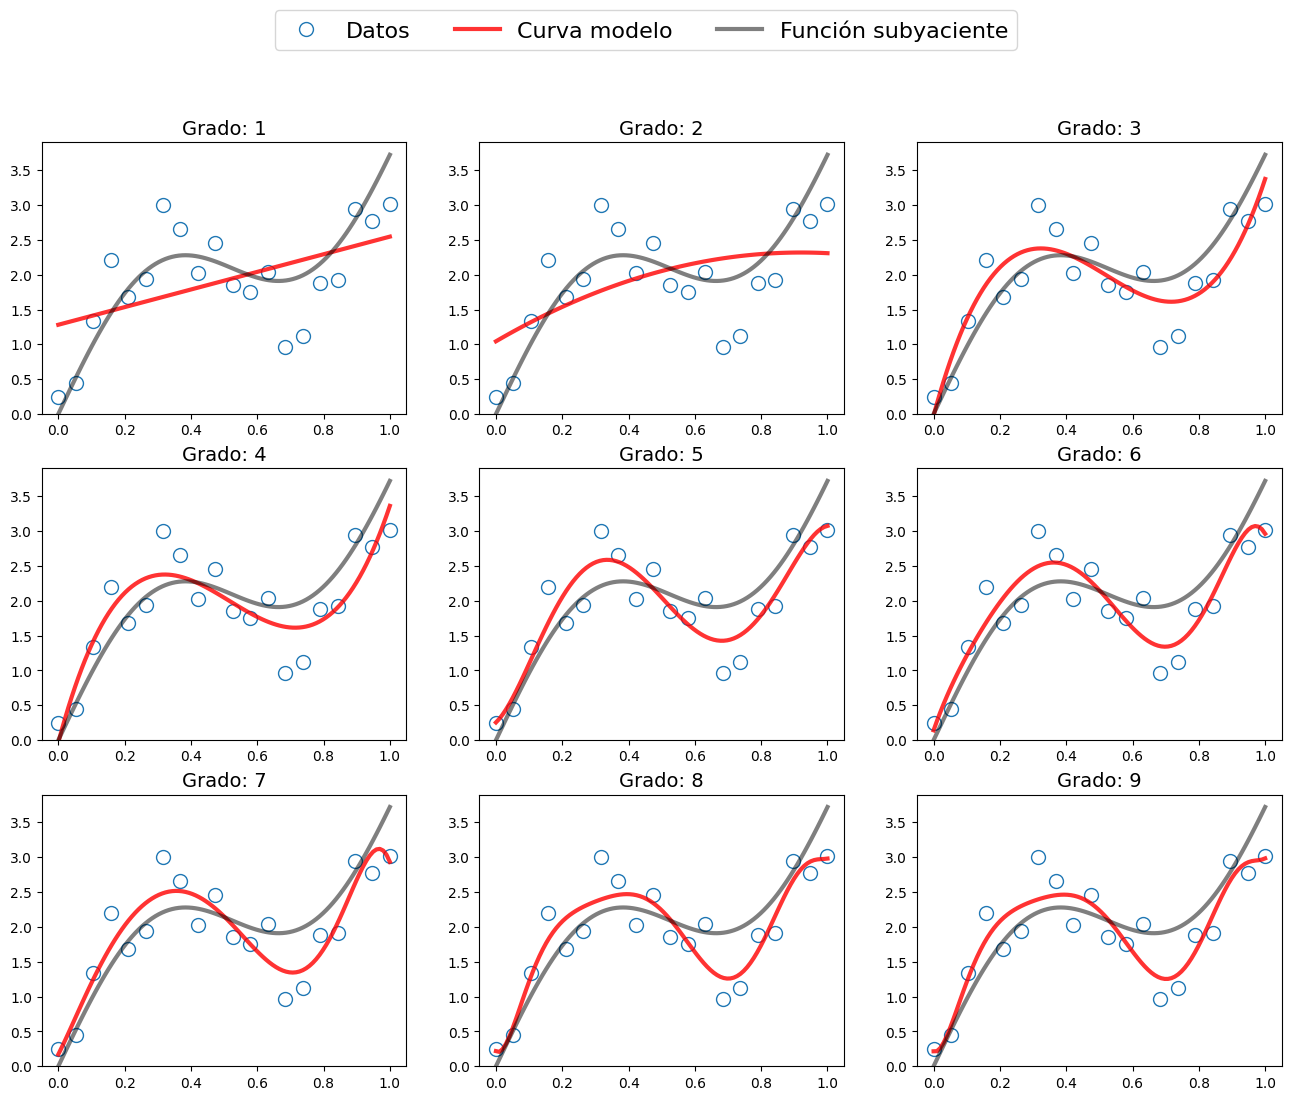

In [63]:
# Perform multi-plot
ncolumns = 3

fig = plt.figure(figsize=(16, 12))

if M % ncolumns == 0: #len(models)
    extrarow = 0
else:
    extrarow = 1
        
axs = fig.subplots(ncols=ncolumns, nrows=int(np.floor(len(models)/ncolumns) + extrarow))

x_ = np.linspace(0,1, 100).reshape(-1,1)
for i, ax in zip(range(len(models)), axs.flatten()):
    ax.plot(x, t, 'o', ms=10, mfc='None', label='Datos')
    ax.plot(x_, models[i].predict(x_), 'r-', lw=3, alpha=0.8, label='Curva modelo')
    ax.plot(x_, ground_truth(x_), 'k-', lw=3, alpha=0.5, label='Función subyaciente')
    #
    ax.set_title('Grado: {}'.format(models[i]['poly_features'].degree), fontsize=14)
    #
    ax.set_ylim(0, 3.9)
    
# Make a single legend
handles, labels = ax.get_legend_handles_labels()
_ = fig.legend(handles, labels, loc='upper center', ncol=len(handles), 
               fontsize=16, borderaxespad=0.5)

¿Conviene aumentar el grado del polinómio? ¿Que pasaría si tuviéramos menos puntos? ¿Estamos realmente aprendiendo algo sobre la función subyaciente?